In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/MyDrive/Image_Processing")

Mounted at /content/drive


In [ ]:
#import libraries
import cv2
import numpy as np

#to display at jupyter notebook
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 8]

<h2> Đọc và hiển thị ảnh <h2>

In [ ]:
iname = 'Finding/2.jpg'
img = cv2.imread(iname)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [ ]:
img.shape

(2560, 2560, 3)

In [ ]:
h, w, num_channels = img.shape

In [ ]:
img.size

19660800

In [ ]:
img.dtype

dtype('uint8')

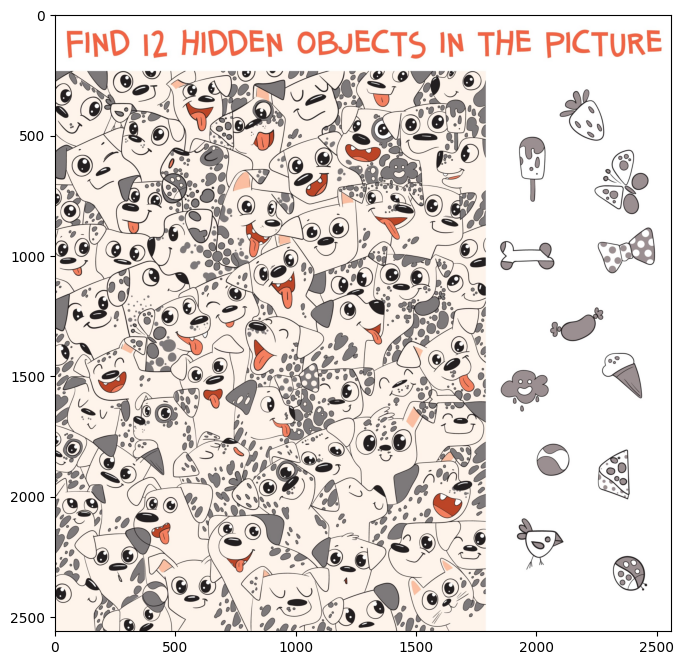

In [ ]:
#display rgb image
plt.imshow(img_rgb)
plt.show()

<h2> Để sử dụng phương pháp Template matching, trước tiên ta phải tách riêng các ảnh chính và các template <h2>

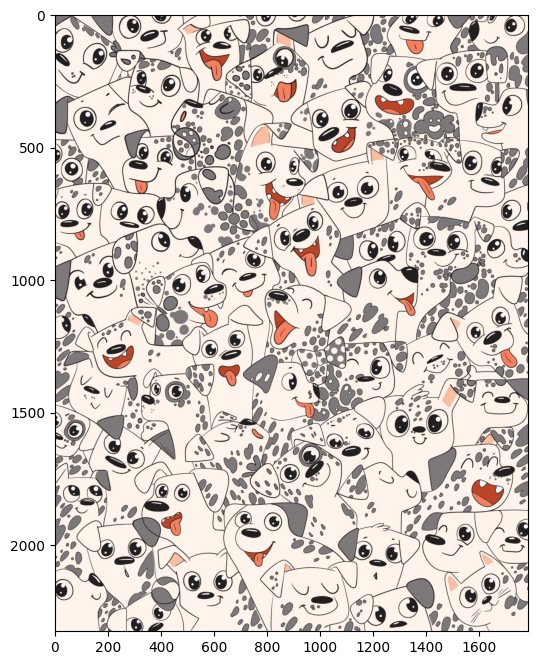

In [ ]:
# Target
target = cv2.imread('Target/target.png')
target_gray = cv2.cvtColor(target, cv2.COLOR_BGR2GRAY)
target_rgb = cv2.cvtColor(target, cv2.COLOR_BGR2RGB)
plt.imshow(target_rgb)
plt.show()

In [ ]:
# Lấy templates
template_paths = os.listdir('Template')
templates = []
for path in template_paths:
    template = cv2.imread(os.path.join('Template', path))
    template_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
    templates.append(template_gray)


<h2> Sử dụng template matching cơ bản <h2>


In [ ]:
# Hàm tìm template
def basic_template_matching(target_gray, template_gray):
  # Tìm template gốc
  result = cv2.matchTemplate(target_gray, template_gray, cv2.TM_CCOEFF_NORMED)
  # Lấy vị trí tốt nhất
  min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

  # Vẽ hình chữ nhật quanh vùng tìm thấy
  h, w = template_gray.shape[:2]
  im_target = target.copy()
  cv2.rectangle(im_target, max_loc, (max_loc[0] + w, max_loc[1] + h), (0, 255, 0), 5)

  # Hiển thị kết quả
  plt.subplot(1, 2, 1)
  plt.imshow(cv2.cvtColor(template_gray, cv2.COLOR_BGR2RGB))
  plt.title('Template')

  plt.subplot(1, 2, 2)
  plt.imshow(cv2.cvtColor(im_target, cv2.COLOR_BGR2RGB))
  plt.title('Target (Matched)')
  plt.show()
  return max_loc, (max_loc[0] + w, max_loc[1] + h)


In [ ]:
results = []

for template_gray in templates:
    max_loc, bottom_right = basic_template_matching(target_gray, template_gray)
    results.append((max_loc, bottom_right))

Output hidden; open in https://colab.research.google.com to view.

<h2> Ta có thể thấy chỉ một vài template được detect chính xác, vậy dùng template matching cơ bản có nhiều hạn chế khi gặp thay đổi về kích thước, xoay, ánh sáng và nhiễu <h2>

<h2> Cải tiến bằng cách thêm edge detection để tăng độ chính xác, ta cần chuyển ảnh target và template về ảnh cạnh, giúp template matching ổn định hơn với ánh sáng thay đổi <h2>

In [ ]:
def find_template_with_edges(target_gray: np.array, template_gray: np.array) -> np.array:
    # Tìm cạnh
    target_edges = cv2.Canny(target_gray, 100, 200)
    template_edges = cv2.Canny(template_gray, 100, 200)
    # Tìm template
    result = cv2.matchTemplate(target_edges, template_edges, cv2.TM_CCOEFF_NORMED)
    # Lấy vị trí tốt nhất
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

    h,w = template_gray.shape[:2]
    im_target = target.copy()
    cv2.rectangle(im_target, max_loc, (max_loc[0] + w, max_loc[1] + h), (0, 255, 0), 5)

    # Hiển thị kết quả
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(template_gray, cv2.COLOR_BGR2RGB))
    plt.title('Template')

    plt.subplot(1, 3, 2)
    plt.imshow(template_edges, cmap="gray")
    plt.title('Template edges')

    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(im_target, cv2.COLOR_BGR2RGB))
    plt.title('Target (Matched)')
    plt.show()

    return max_loc, (max_loc[0] + w, max_loc[1] + h)



In [ ]:
results = []
for template_gray in templates:
    max_loc, bottom_right = find_template_with_edges(target_gray, template_gray)
    results.append((max_loc, bottom_right))

Output hidden; open in https://colab.research.google.com to view.

<h2> Sau khi dùng canny edges mà kết quả vẫn không khả quan hơn, có thể do template có kích thước khác so với ảnh gốc hoặc ảnh có thể bị thu phóng, biến dạng <h2>

Giải pháp: Dùng multi-scale template matching:

- Thử nhiều tỷ lệ khác nhau của template (scale)

- Tìm scale có điểm tương đồng (match score) cao nhất

Thêm scale

In [ ]:
def scale_img(img, scale):
    """ Resize ảnh theo scale """
    width = int(img.shape[1] * scale)
    height = int(img.shape[0] * scale)
    return cv2.resize(img, (width, height))

In [ ]:
def find_template(target_gray: np.array, template_gray: np.array, ratios: list) -> np.array:
  _min_val, _max_val, _min_loc, _max_loc = [], [], [], []
  target_edges = cv2.Canny(target_gray, 100, 200)

  for ratio in ratios:
    scaled_template = scale_img(template_gray, ratio)
    # Tìm cạnh template đã scale
    template_edges = cv2.Canny(scaled_template, 100, 200)
    result = cv2.matchTemplate(target_edges, template_edges, cv2.TM_CCOEFF_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

    # Lưu lại các giá trị
    _min_val.append(min_val)
    _max_val.append(max_val)
    _min_loc.append(min_loc)
    _max_loc.append(max_loc)

  # Lấy vị trí tốt nhất (tương ứng với max_val lớn nhất)
  best_idx = np.argmax(_max_val)
  best_max_loc = _max_loc[best_idx]
  best_w, best_h = scale_img(template_gray, ratios[best_idx]).shape[1], scale_img(template_gray, ratios[best_idx]).shape[0]

  # Vẽ hình chữ nhật quanh vị trí tìm thấy tốt nhất
  im_target = target.copy()
  cv2.rectangle(im_target, best_max_loc, (best_max_loc[0] + best_w, best_max_loc[1] + best_h), (0, 255, 0), 2)

  # Hiển thị kết quả
  plt.subplot(1, 2, 1)
  plt.imshow(template_gray, cmap="gray")
  plt.title("Template")

  plt.subplot(1, 2, 2)
  plt.imshow(cv2.cvtColor(im_target, cv2.COLOR_BGR2RGB))
  plt.title("Target (Matched)")

  plt.show()

  return best_max_loc, (best_max_loc[0] + best_w, best_max_loc[1] + best_h)

In [ ]:
result = []
ratios = np.linspace(0.8, 2, 50).tolist()
for template_gray in templates:
    max_loc, bottom_right = find_template(target_gray, template_gray, ratios)
    result.append((max_loc, bottom_right))

Output hidden; open in https://colab.research.google.com to view.

## Tổng kết



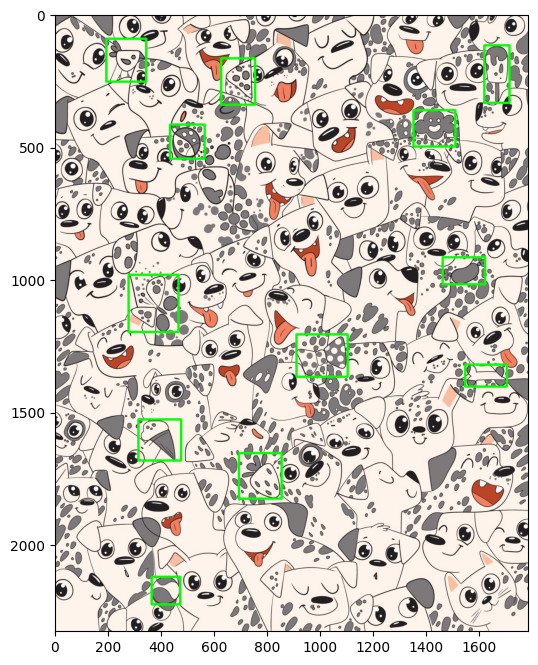

In [ ]:
img_result = target.copy()
for res in result:
    cv2.rectangle(img_result, res[0], res[1], (0, 255, 0), 8)
plt.imshow(cv2.cvtColor(img_result, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
# Lưu ảnh kết quả
cv2.imwrite("result.png", img_result)

True